<h1>Project: Affordability of a Healthy Diet</h1>
<h2>Introduction</h2>

The affordability of a healthy diet is a critical issue for global food security and public health. While starchy staples often provide cheap calories, nutrient-rich foods such as fruits, vegetables, and animal-source products can remain out of reach for many populations. Understanding what drives this affordability gap is essential for governments, NGOs, and policymakers aiming to reduce malnutrition and inequality.

In this project, we use the World Bank Cost of a Healthy Diet (CoHD) dataset to explore global food prices and their relationship to the percentage of the population unable to afford a healthy diet. All cost measures are expressed in Purchasing Power Parity (PPP) dollars, which allows for meaningful comparison across countries by adjusting for differences in local purchasing power.

<h2>Dataset overview</h2>

While the dataset has many more interesting data points and spans the years 2017-2024 due to missing data the analysis only looks at 2021.

Features:
- Cost of fruits in PPP dollars (CoHD_f_PPP)
- Cost of vegetables (CoHD_v_PPP)
- Cost of starchy staples (CoHD_ss_PPP)
- Cost of animal-source foods (CoHD_asf_PPP)
- Cost of legumes, nuts, and seeds (CoHD_lns_PPP)
- Cost of oils and fats (CoHD_of_PPP)

Target: Percent of the population unable to afford a healthy diet (CoHD_headcount)

Coverage: 192 countries (of which 158 have complete data for 2021).

<h2>Goals of the analysis</h2>

This notebook follows the CRISP-DM process (Cross Industry Standard Process for Data Mining) to structure the analysis. The key business/research questions we aim to answer are:

1. What is the distribution of food group costs across countries?
2. Which food costs correlate most with the affordability of a healthy diet?
3. Can we predict unaffordability based on food group prices?

By combining exploratory data analysis (EDA), statistical correlation, and a predictive model (RandomForestRegressor), we aim to understand not only the drivers of affordability but also the predictive power of food group costs for identifying populations at risk.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

<h2>Exploratory Data Analysis</h2>

In the following code blocks we explore the original dataset which contains more than 40 features. Most of the column are objects, which we need to transform later. We also remove the features that are not of interest to obtain a smaller subset of the data.

In [6]:
nutrition = pd.read_csv("/Users/sandramerkel/Documents/ND_datascience/project_1_nutrition/data/nutri_data.csv", encoding="latin1")
nutrition.head(20)

,Classification Name,Classification Code,Country Name,Country Code,Time,Time Code,Cost of an energy sufficient diet in PPP dollars [CoCA_PPP],Cost of a nutrient adequate diet in PPP dollars [CoNA_PPP],Cost of a healthy diet in PPP dollars [CoHD_PPP],Cost of fruits in PPP dollars [CoHD_f_PPP],...,Affordability of an energy sufficient diet: ratio of cost to food expenditures [CoCA_fexp],Affordability of a nutrient adequate diet: ratio of cost to food expenditures [CoNA_fexp],Affordability of a healthy diet: ratio of cost to food expenditures [CoHD_fexp],Percent of the population who cannot afford sufficient calories [CoCA_headcount],Percent of the population who cannot afford nutrient adequacy [CoNA_headcount],Percent of the population who cannot afford a healthy diet [CoHD_headcount],Millions of people who cannot afford sufficient calories [CoCA_unafford_n],Millions of people who cannot afford nutrient adequacy [CoNA_unafford_n],Millions of people who cannot afford a healthy diet [CoHD_unafford_n],Population [Pop]
0,Food Prices for Nutrition 4.0,FPN 4.0,Albania,ALB,2017.0,YR2017,..,..,3.04,..,...,..,..,..,..,..,24.3,..,..,0.7,2898242
1,Food Prices for Nutrition 4.0,FPN 4.0,Albania,ALB,2018.0,YR2018,..,..,3.13,..,...,..,..,..,..,..,17.6,..,..,0.5,2894231
2,Food Prices for Nutrition 4.0,FPN 4.0,Albania,ALB,2019.0,YR2019,..,..,3.32,..,...,..,..,..,..,..,14.6,..,..,0.4,2885010
3,Food Prices for Nutrition 4.0,FPN 4.0,Albania,ALB,2020.0,YR2020,..,..,3.4,..,...,..,..,..,..,..,13.9,..,..,0.4,2871954
4,Food Prices for Nutrition 4.0,FPN 4.0,Albania,ALB,2021.0,YR2021,0.84,2.59,3.49,0.77,...,0.08,0.24,0.32,3.3,8.9,12.6,0.1,0.3,0.4,2849635
5,Food Prices for Nutrition 4.0,FPN 4.0,Albania,ALB,2022.0,YR2022,..,..,4.14,..,...,..,..,..,..,..,11.7,..,..,0.3,2827608
6,Food Prices for Nutrition 4.0,FPN 4.0,Albania,ALB,2023.0,YR2023,..,..,4.58,..,...,..,..,..,..,..,11.4,..,..,0.3,2811655
7,Food Prices for Nutrition 4.0,FPN 4.0,Albania,ALB,2024.0,YR2024,..,..,4.77,..,...,..,..,..,..,..,10.7,..,..,0.3,2791765
8,Food Prices for Nutrition 4.0,FPN 4.0,Algeria,DZA,2017.0,YR2017,..,..,4.09,..,...,..,..,..,..,..,18.8,..,..,7.8,41689299
9,Food Prices for Nutrition 4.0,FPN 4.0,Algeria,DZA,2018.0,YR2018,..,..,4.16,..,...,..,..,..,..,..,18.1,..,..,7.7,42505035


In [10]:
nutrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 49 columns):
 #   Column                                                                                                      Non-Null Count  Dtype  
---  ------                                                                                                      --------------  -----  
 0   Classification Name                                                                                         1538 non-null   object 
 1   Classification Code                                                                                         1536 non-null   object 
 2   Country Name                                                                                                1536 non-null   object 
 3   Country Code                                                                                                1536 non-null   object 
 4   Time                                                              

In [24]:
#keeping only the essential columns
keep_cols = [
    "Time",
    "Cost of fruits in PPP dollars [CoHD_f_PPP]",
    "Country Name",
    "Cost of vegetables in PPP dollars [CoHD_v_PPP]",
    "Cost of starchy staples in PPP dollars [CoHD_ss_PPP]",
    "Cost of animal source foods in PPP dollars [CoHD_asf_PPP]",
    "Cost of legumes, nuts and seeds in PPP dollars [CoHD_lns_PPP]",
    "Cost of fats and oils in PPP dollars [CoHD_of_PPP]",
    "Percent of the population who cannot afford a healthy diet [CoHD_headcount]" 
]

In [4]:
nutri_sub = nutrition[keep_cols]

When looking at the data, one can see that there is only data available for one year - 2021. In the following blocks we limit the data to 2021, convert the objects into float and remove rows with missing values.

In [5]:
nutri_sub.head(25)

,Time,Cost of fruits in PPP dollars [CoHD_f_PPP],Country Name,Cost of vegetables in PPP dollars [CoHD_v_PPP],Cost of starchy staples in PPP dollars [CoHD_ss_PPP],Cost of animal source foods in PPP dollars [CoHD_asf_PPP],"Cost of legumes, nuts and seeds in PPP dollars [CoHD_lns_PPP]",Cost of fats and oils in PPP dollars [CoHD_of_PPP],Percent of the population who cannot afford a healthy diet [CoHD_headcount]
0,2017.0,..,Albania,..,..,..,..,..,24.3
1,2018.0,..,Albania,..,..,..,..,..,17.6
2,2019.0,..,Albania,..,..,..,..,..,14.6
3,2020.0,..,Albania,..,..,..,..,..,13.9
4,2021.0,0.77,Albania,0.6,0.48,1.13,0.41,0.11,12.6
5,2022.0,..,Albania,..,..,..,..,..,11.7
6,2023.0,..,Albania,..,..,..,..,..,11.4
7,2024.0,..,Albania,..,..,..,..,..,10.7
8,2017.0,..,Algeria,..,..,..,..,..,18.8
9,2018.0,..,Algeria,..,..,..,..,..,18.1


In [6]:
# Keeps only data from 2021
nutri_sub = nutri_sub[nutri_sub["Time"] == 2021]

In [7]:
nutri_sub.head(20)

,Time,Cost of fruits in PPP dollars [CoHD_f_PPP],Country Name,Cost of vegetables in PPP dollars [CoHD_v_PPP],Cost of starchy staples in PPP dollars [CoHD_ss_PPP],Cost of animal source foods in PPP dollars [CoHD_asf_PPP],"Cost of legumes, nuts and seeds in PPP dollars [CoHD_lns_PPP]",Cost of fats and oils in PPP dollars [CoHD_of_PPP],Percent of the population who cannot afford a healthy diet [CoHD_headcount]
4,2021.0,0.77,Albania,0.6,0.48,1.13,0.41,0.11,12.6
12,2021.0,1.1,Algeria,0.72,0.56,1.36,0.58,0.15,19.6
20,2021.0,0.75,Angola,0.44,1.15,1.15,0.42,0.21,69.8
28,2021.0,1.22,Anguilla,1.01,0.75,0.63,0.37,0.15,..
36,2021.0,1.59,Antigua and Barbuda,1.26,0.67,0.8,0.48,0.13,..
44,2021.0,..,Argentina,..,..,..,..,..,..
52,2021.0,0.92,Armenia,0.6,0.59,1.04,0.4,0.25,54.4
60,2021.0,1.09,Aruba,1,0.56,0.74,0.46,0.14,..
68,2021.0,0.78,Australia,0.73,0.25,0.5,0.27,0.09,3.2
76,2021.0,0.72,Austria,0.73,0.27,0.55,0.1,0.06,2.9


In [8]:
nutri_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, 4 to 1532
Data columns (total 9 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Time                                                                         192 non-null    float64
 1   Cost of fruits in PPP dollars [CoHD_f_PPP]                                   192 non-null    object 
 2   Country Name                                                                 192 non-null    object 
 3   Cost of vegetables in PPP dollars [CoHD_v_PPP]                               192 non-null    object 
 4   Cost of starchy staples in PPP dollars [CoHD_ss_PPP]                         192 non-null    object 
 5   Cost of animal source foods in PPP dollars [CoHD_asf_PPP]                    192 non-null    object 
 6   Cost of legumes, nuts and seeds in PPP dollars 

In [25]:
nutri_sub = nutri_sub.replace("..", np.nan)
numb_cols = [
    "Cost of fruits in PPP dollars [CoHD_f_PPP]",
    "Cost of vegetables in PPP dollars [CoHD_v_PPP]",
    "Cost of starchy staples in PPP dollars [CoHD_ss_PPP]",
    "Cost of animal source foods in PPP dollars [CoHD_asf_PPP]",
    "Cost of legumes, nuts and seeds in PPP dollars [CoHD_lns_PPP]",
    "Cost of fats and oils in PPP dollars [CoHD_of_PPP]",
    "Percent of the population who cannot afford a healthy diet [CoHD_headcount]"
]

# Convert only those columns to numeric
nutri_sub[numb_cols] = nutri_sub[numb_cols].apply(pd.to_numeric, errors="coerce")

In [26]:
# Dropping all rows that don't have a value for the target variable
nutri_sub = nutri_sub.dropna(subset=["Percent of the population who cannot afford a healthy diet [CoHD_headcount]"])

In [11]:
nutri_sub.head(30)

,Time,Cost of fruits in PPP dollars [CoHD_f_PPP],Country Name,Cost of vegetables in PPP dollars [CoHD_v_PPP],Cost of starchy staples in PPP dollars [CoHD_ss_PPP],Cost of animal source foods in PPP dollars [CoHD_asf_PPP],"Cost of legumes, nuts and seeds in PPP dollars [CoHD_lns_PPP]",Cost of fats and oils in PPP dollars [CoHD_of_PPP],Percent of the population who cannot afford a healthy diet [CoHD_headcount]
4,2021.0,0.77,Albania,0.60,0.48,1.13,0.41,0.11,12.6
12,2021.0,1.10,Algeria,0.72,0.56,1.36,0.58,0.15,19.6
20,2021.0,0.75,Angola,0.44,1.15,1.15,0.42,0.21,69.8
52,2021.0,0.92,Armenia,0.60,0.59,1.04,0.40,0.25,54.4
68,2021.0,0.78,Australia,0.73,0.25,0.50,0.27,0.09,3.2
76,2021.0,0.72,Austria,0.73,0.27,0.55,0.10,0.06,2.9
84,2021.0,0.66,Azerbaijan,0.46,0.68,1.09,0.37,0.19,0.8
108,2021.0,0.66,Bangladesh,0.76,0.46,1.55,0.27,0.13,52.6
124,2021.0,0.94,Belarus,0.48,0.58,0.84,0.26,0.20,1.0
132,2021.0,0.74,Belgium,0.63,0.22,0.53,0.10,0.05,0.7


In [12]:
#successful conversion
nutri_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162 entries, 4 to 1524
Data columns (total 9 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Time                                                                         162 non-null    float64
 1   Cost of fruits in PPP dollars [CoHD_f_PPP]                                   158 non-null    float64
 2   Country Name                                                                 162 non-null    object 
 3   Cost of vegetables in PPP dollars [CoHD_v_PPP]                               158 non-null    float64
 4   Cost of starchy staples in PPP dollars [CoHD_ss_PPP]                         158 non-null    float64
 5   Cost of animal source foods in PPP dollars [CoHD_asf_PPP]                    158 non-null    float64
 6   Cost of legumes, nuts and seeds in PPP dollars 

After the pre-processing of the data, it is ready for analysis. 158 countries have complete data. Looking at the mean we can see that fats and oils are cheapest, animal source foods are the most expensive foods.

In [14]:
nutri_2011 = nutri_sub.dropna().drop(columns=["Time"]).reset_index(drop=True)
nutri_2011.describe()

,Cost of fruits in PPP dollars [CoHD_f_PPP],Cost of vegetables in PPP dollars [CoHD_v_PPP],Cost of starchy staples in PPP dollars [CoHD_ss_PPP],Cost of animal source foods in PPP dollars [CoHD_asf_PPP],"Cost of legumes, nuts and seeds in PPP dollars [CoHD_lns_PPP]",Cost of fats and oils in PPP dollars [CoHD_of_PPP],Percent of the population who cannot afford a healthy diet [CoHD_headcount]
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,0.664937,0.738797,0.569873,1.018544,0.380000,0.171962,32.794304
std,0.288026,0.272655,0.191095,0.278272,0.138578,0.078460,27.244679
min,0.170000,0.210000,0.150000,0.460000,0.100000,0.050000,0.000000
25%,0.452500,0.530000,0.460000,0.812500,0.300000,0.112500,7.600000
50%,0.655000,0.730000,0.580000,1.005000,0.350000,0.160000,26.050000
75%,0.807500,0.897500,0.670000,1.197500,0.420000,0.210000,55.075000
max,2.500000,1.690000,1.470000,1.820000,1.030000,0.480000,93.800000


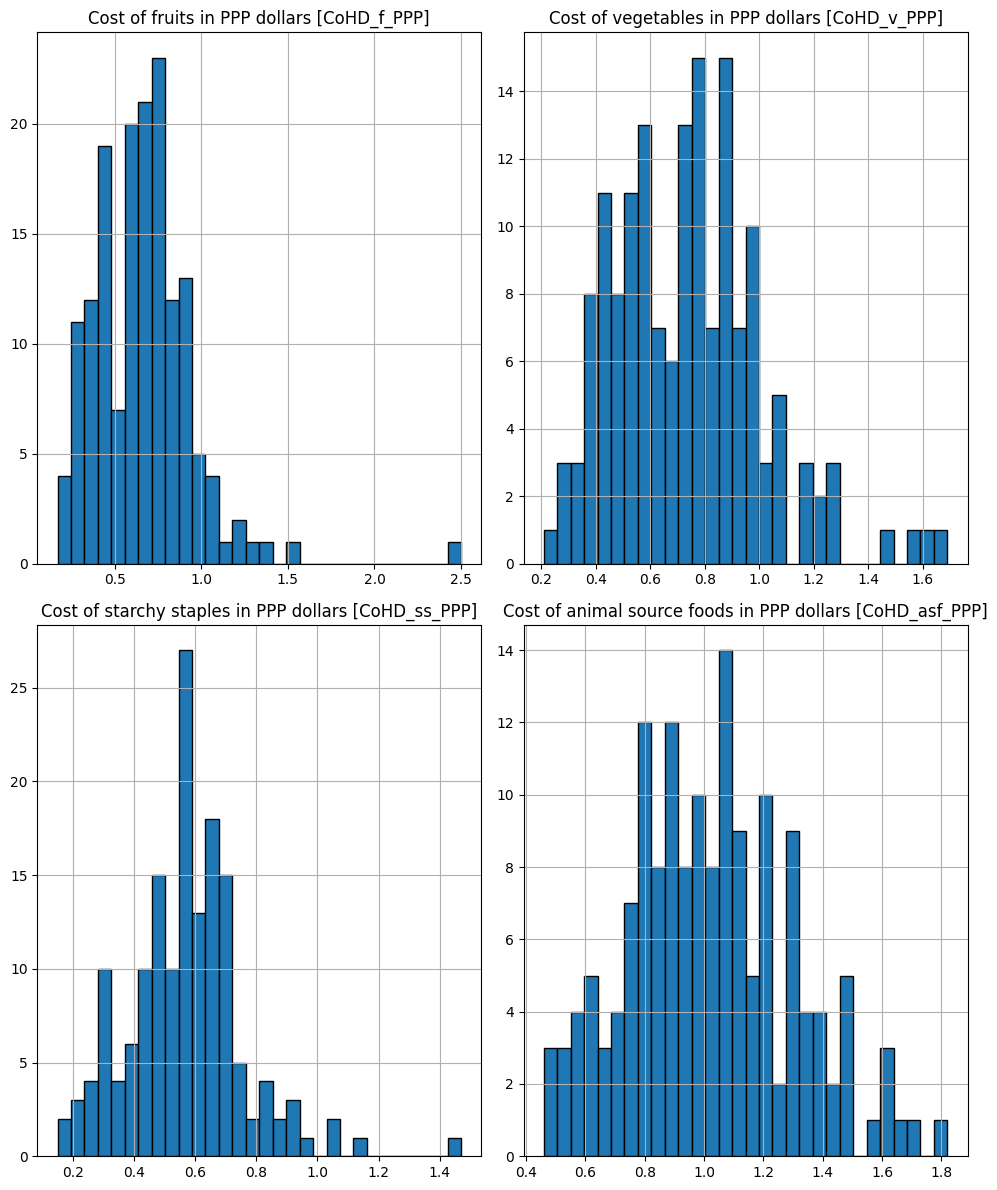

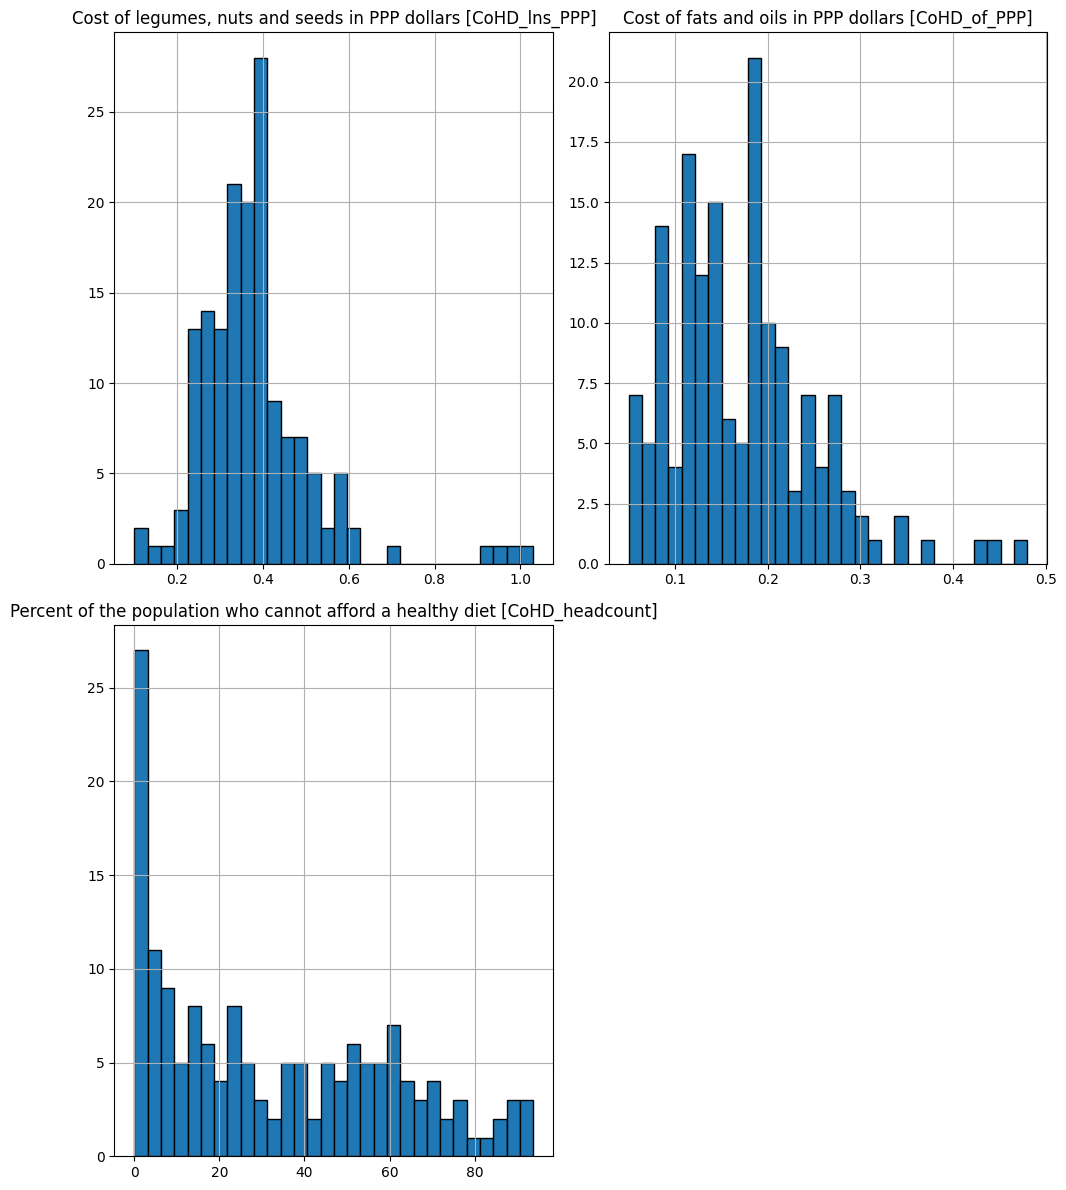

In [ ]:
# Plot in chunks of 2 columns
num_cols = nutri_2011.select_dtypes(include=["number"]).columns
for i in range(0, len(num_cols), 4):
    nutri_2011[num_cols[i:i+4]].hist(
        bins=30, figsize=(10, 12), layout=(2, 2), edgecolor="black"
    )
    plt.tight_layout()
    plt.show()

<h3>1. What is the distribution of food group costs across countries?</h3>
To explore this, I plotted histograms for each of the six food groups (in PPP dollars).

Findings:

Starchy staples and legumes/nuts/seeds are the cheapest categories overall, with most countries clustering below 0.6 PPP dollars. This reflects their role as affordable calorie sources.

Oils and fats are also low-cost, often below 0.4 PPP dollars, making them a dense and inexpensive source of energy.

Fruits and vegetables have wider distributions, ranging roughly 0.2–0.8 PPP dollars, reflecting regional differences in production and availability.

Animal-source foods are consistently the most expensive category, with many countries above 0.8 PPP dollars.

Interpretation:
The distributions suggest that while staple calories are relatively affordable worldwide, nutrient-rich categories such as animal-source foods—and to some extent fruits and vegetables—represent the biggest affordability challenge. This gap helps explain why achieving dietary diversity remains more difficult than simply meeting caloric needs.

The distribution of diet unaffordability is right-skewed. Many countries show very low unaffordability (0–10%), while others fall in a middle range (20–60%), and a smaller group face extreme levels (>60%). This polarization highlights that although most populations can afford a healthy diet, some countries face severe challenges, making it crucial to focus on high-risk cases rather than just global averages.

Now, I explored the correlation of the features with the target variable.

In [29]:
# Compute correlation matrix using only numeric columns
corr_matrix = nutri_2011.select_dtypes(include=["number"]).corr()

# Show top correlations with the target
target_col = "Percent of the population who cannot afford a healthy diet [CoHD_headcount]"
print(corr_matrix[target_col].sort_values(ascending=False))

Percent of the population who cannot afford a healthy diet [CoHD_headcount]    1.000000
Cost of animal source foods in PPP dollars [CoHD_asf_PPP]                      0.656692
Cost of fats and oils in PPP dollars [CoHD_of_PPP]                             0.467147
Cost of starchy staples in PPP dollars [CoHD_ss_PPP]                           0.417958
Cost of legumes, nuts and seeds in PPP dollars [CoHD_lns_PPP]                 -0.078415
Cost of vegetables in PPP dollars [CoHD_v_PPP]                                -0.259122
Cost of fruits in PPP dollars [CoHD_f_PPP]                                    -0.440415
Name: Percent of the population who cannot afford a healthy diet [CoHD_headcount], dtype: float64


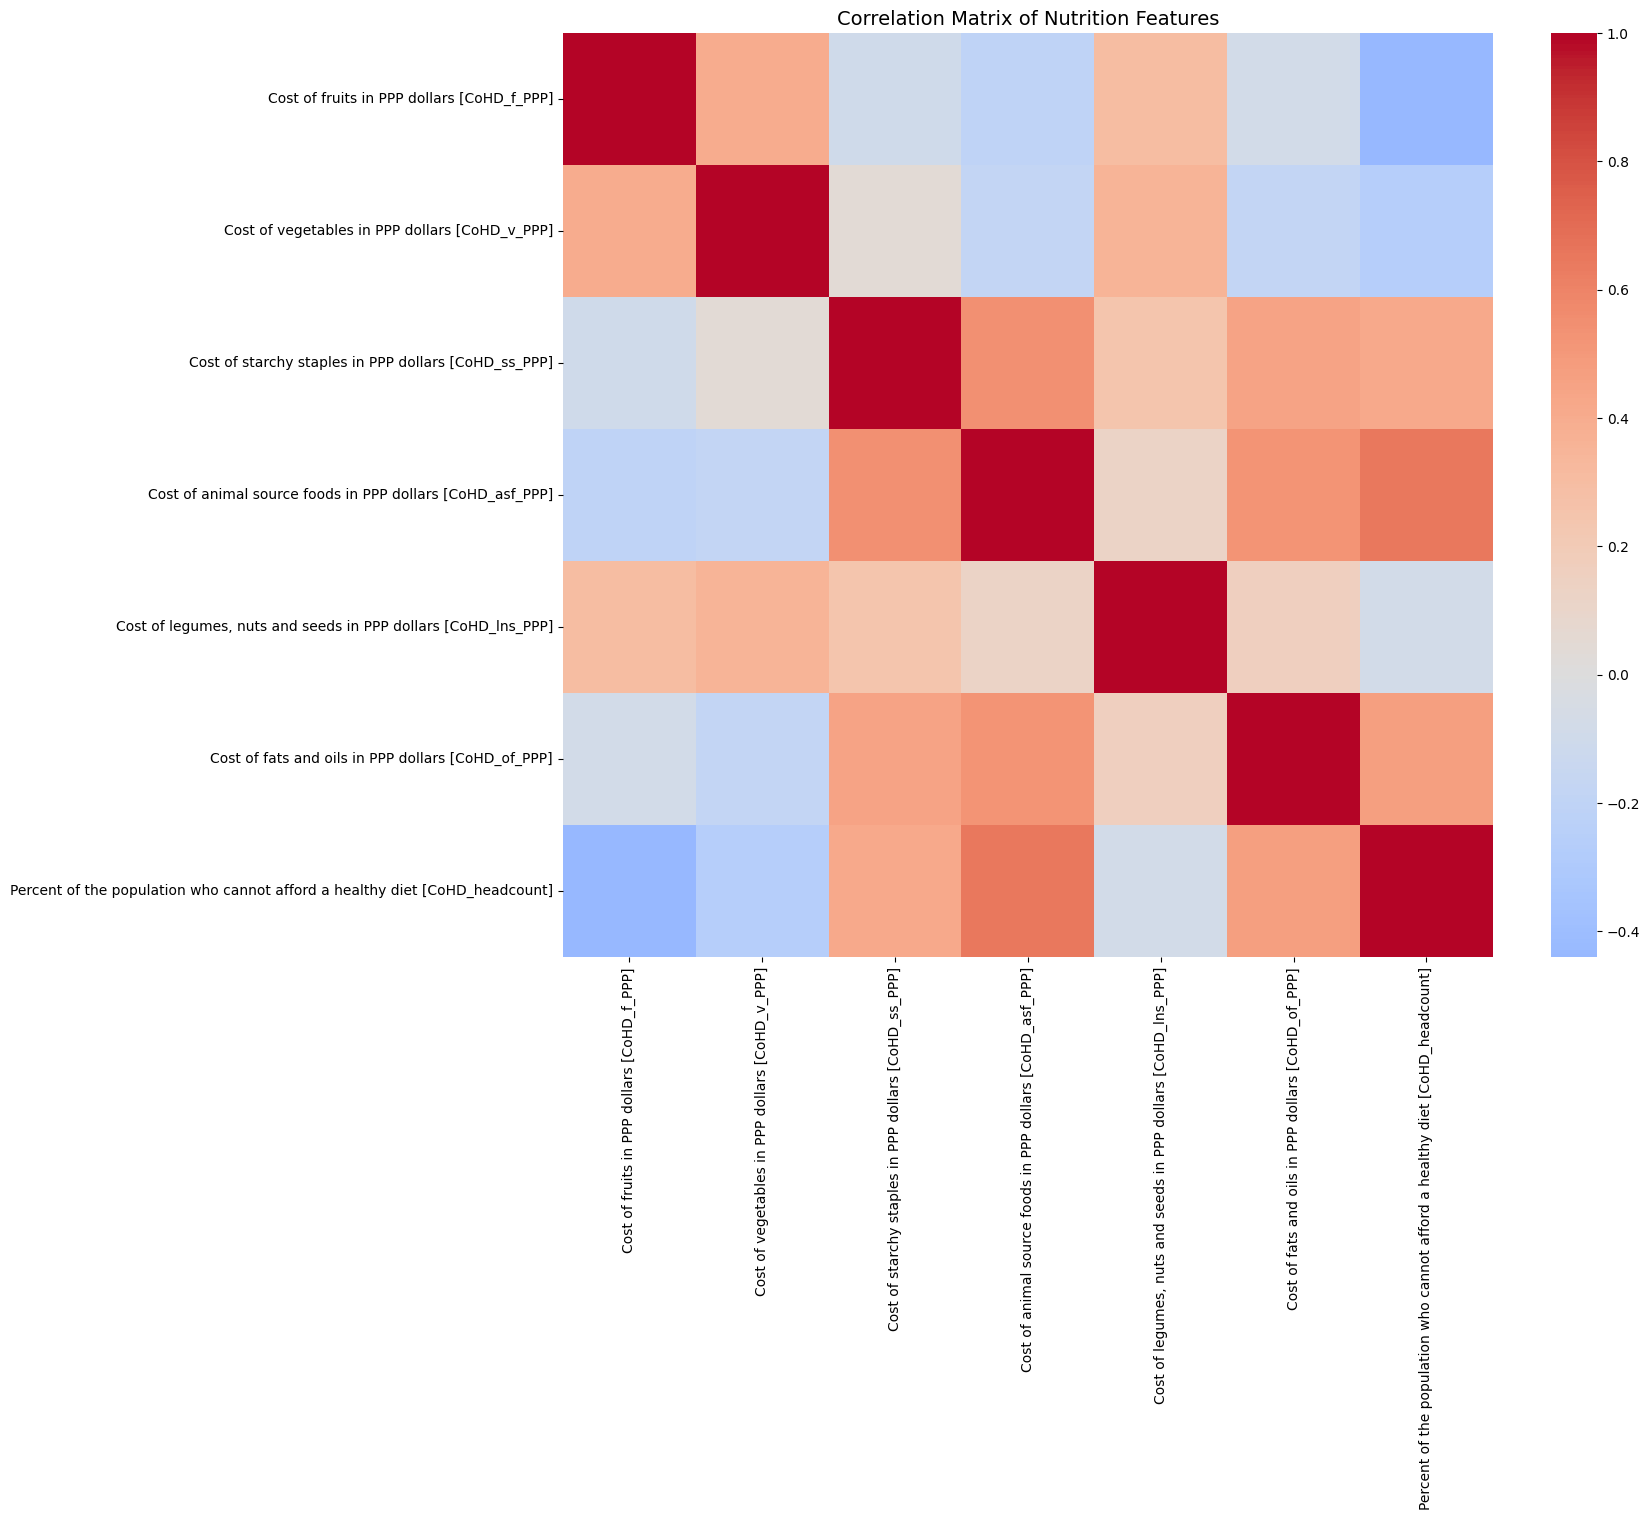

In [17]:
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, cbar=True)
plt.title("Correlation Matrix of Nutrition Features", fontsize=14)
plt.show()

<h3>2. Which food costs correlate most with the affordability of a healthy diet?</h3>

To address this question, I computed pairwise correlations between each food group cost (CoHD_x_PPP) and the target variable: the percentage of the population unable to afford a healthy diet.

Findings:

- Animal-source foods (CoHD_asf_PPP): Strongest positive correlation (r ≈ 0.66)
- Fats and oils (CoHD_of_PPP): Moderate positive correlation (r ≈ 0.47)
- Starchy staples (CoHD_ss_PPP): Moderate positive correlation (r ≈ 0.42)
- Fruits (CoHD_f_PPP): Negative correlation (r ≈ –0.44)
- Vegetables (CoHD_v_PPP): Negative correlation (r ≈ –0.26)
- Legumes/nuts/seeds (CoHD_lns_PPP): Weak or near-zero correlation

Interpretation:
The strongest drivers of unaffordability are the costs of animal-source foods, staples, and oils—all categories that are calorie-dense. This makes sense: when the basic sources of energy become more expensive, large parts of the population cannot secure enough calories for a minimum healthy diet.

In [32]:
nutri_2011.head()

,Cost of fruits in PPP dollars [CoHD_f_PPP],Country Name,Cost of vegetables in PPP dollars [CoHD_v_PPP],Cost of starchy staples in PPP dollars [CoHD_ss_PPP],Cost of animal source foods in PPP dollars [CoHD_asf_PPP],"Cost of legumes, nuts and seeds in PPP dollars [CoHD_lns_PPP]",Cost of fats and oils in PPP dollars [CoHD_of_PPP],Percent of the population who cannot afford a healthy diet [CoHD_headcount]
0,0.77,Albania,0.60,0.48,1.13,0.41,0.11,12.6
1,1.10,Algeria,0.72,0.56,1.36,0.58,0.15,19.6
2,0.75,Angola,0.44,1.15,1.15,0.42,0.21,69.8
3,0.92,Armenia,0.60,0.59,1.04,0.40,0.25,54.4
4,0.78,Australia,0.73,0.25,0.50,0.27,0.09,3.2


<h3>3: Can we predict unaffordability based on food group prices?</h3>

To test the predictive power of food costs, I trained a RandomForestRegressor using the six CoHD_x_PPP features as inputs and the percentage of the population unable to afford a healthy diet as the target.

Results (test set):

RMSE ≈ 16.1 (percentage points of the population)
R² ≈ 0.65

Interpretation:
The model explains about 65% of the variance in diet unaffordability across countries, which is a strong result given that many other structural factors (e.g., income levels, subsidies, trade policies, agricultural productivity) are not included in the dataset.

The relatively low RMSE suggests that food prices alone provide a meaningful signal for predicting whether populations can afford a healthy diet. This demonstrates that while economic and social context matter, the cost of key food groups is a central determinant of affordability.

Why Random Forest?
I selected Random Forest because it:

- Handles non-linear relationships between food costs and unaffordability.
- Captures interactions between features (e.g., when both staples and oils are expensive).
- Is robust to skewed data distributions, which is important given the right-skewed target.

In [33]:
# Define target
X = nutri_2011.drop(columns=[target_col, "Country Name"])
y = nutri_2011[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
#This means, on average, your model’s predictions are off by about 5.9 percentage points from the true value of
    
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#R² tells you how much of the variation in the target the model explains.
r2 = r2_score(y_test, y_pred)

print("Random Forest RMSE:", rmse)
print("Random Forest R²:", r2)

Random Forest RMSE: 16.11230098766739
Random Forest R²: 0.645499440889439


<h2>Key takeaways:</h2>

Staples, oils, and animal-source foods are the strongest drivers of unaffordability.

Fruits and vegetables show negative correlations with unaffordability, suggesting their affordability plays a smaller role in contexts where calorie needs are already met.

A Random Forest model explained ~65% of the variation in unaffordability, confirming that food prices alone are a strong predictor.

Broader implications:
Ensuring access to affordable calorie-dense foods appears to be a prerequisite for improving diet affordability globally. At the same time, long-term health requires policies that also make nutrient-rich foods more accessible. Data-driven approaches like this can help identify priority areas for intervention.

In short: while many countries provide cheap staples, the challenge of achieving dietary diversity remains. Making healthy diets affordable everywhere will require coordinated action on both price stability and income growth.